<a href="https://colab.research.google.com/github/JonasZimmer1994/DataScienceProjekt/blob/master/Data_Science_Projekt.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!git clone https://github.com/JonasZimmer1994/DataScienceProjekt.git

Cloning into 'DataScienceProjekt'...
remote: Enumerating objects: 12, done.
remote: Counting objects: 100% (12/12), done.
remote: Compressing objects: 100% (12/12), done.
remote: Total 12 (delta 2), reused 7 (delta 0), pack-reused 0
Unpacking objects: 100% (12/12), done.


In [20]:
#imports
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


Zunächst werden die Dateien in Form von DataFrames importiert.

In [0]:
train = pd.read_csv('/content/DataScienceProjekt/train.csv') 
test = pd.read_csv('/content/DataScienceProjekt/test.csv')

Zur Übersicht werden die Daten erst einmal ausgegeben.

In [4]:
train.head()

,id,keyword,location,text,target
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1


die Form der Daten sieht wie folgt aus

In [8]:
print('There are {} rows and {} columns in train'.format(train.shape[0],train.shape[1]))
print('There are {} rows and {} columns in train'.format(test.shape[0],test.shape[1]))

There are 7613 rows and 5 columns in train
There are 3263 rows and 4 columns in train


um die Daten genauer anzusehen, werden zunächst Beispiel Tweets angezeigt. Dazu wird angeschaut bei welchen Tweets es sich um Disaster Tweets handelt.

In [28]:
for i in range(20):
    print(train.text[i], "        Desaster Tweet:", train.target[i])

Our Deeds are the Reason of this #earthquake May ALLAH Forgive us all         Desaster Tweet: 1
Forest fire near La Ronge Sask. Canada         Desaster Tweet: 1
All residents asked to 'shelter in place' are being notified by officers. No other evacuation or shelter in place orders are expected         Desaster Tweet: 1
13,000 people receive #wildfires evacuation orders in California          Desaster Tweet: 1
Just got sent this photo from Ruby #Alaska as smoke from #wildfires pours into a school          Desaster Tweet: 1
#RockyFire Update => California Hwy. 20 closed in both directions due to Lake County fire - #CAfire #wildfires         Desaster Tweet: 1
#flood #disaster Heavy rain causes flash flooding of streets in Manitou, Colorado Springs areas         Desaster Tweet: 1
I'm on top of the hill and I can see a fire in the woods...         Desaster Tweet: 1
There's an emergency evacuation happening now in the building across the street         Desaster Tweet: 1
I'm afraid that the t

Es wird die Klassenverteilung geplottet

Text(0, 0.5, 'samples')

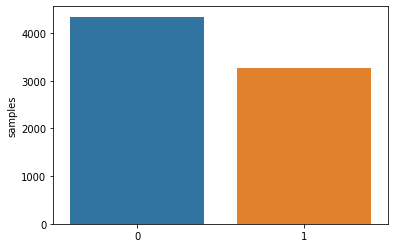

In [22]:
x=train.target.value_counts()
sns.barplot(x.index,x)
plt.gca().set_ylabel('samples')

Um sich ein genaueres Bild von Disaster vs Non-Disaster Tweets zu machen, werden einige Eigenschaften von beiden Arten von Tweets gegenübergestellt.

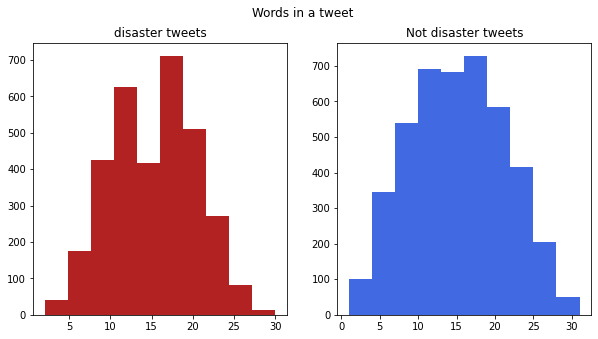

In [37]:
fig,(ax1,ax2)=plt.subplots(1,2,figsize=(10,5))
tweet_len=train[train['target']==1]['text'].str.split().map(lambda x: len(x))
ax1.hist(tweet_len,color='firebrick')
ax1.set_title('disaster tweets')
tweet_len=train[train['target']==0]['text'].str.split().map(lambda x: len(x))
ax2.hist(tweet_len,color='royalblue')
ax2.set_title('Not disaster tweets')
fig.suptitle('Words in a tweet')
plt.show()

anhand der Wort Menge kann man erkennen, dass disaster Tweets tendenziell weniger Wörter beinhalten.

Text(0.5, 0.98, 'Average word length in each tweet')

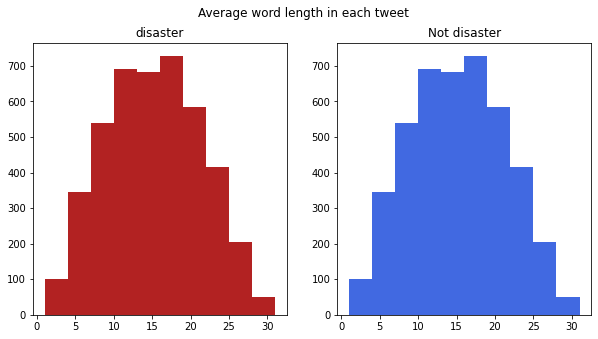

In [41]:
fig,(ax1,ax2)=plt.subplots(1,2,figsize=(10,5))
word=train[train['target']==1]['text'].str.split().apply(lambda x : [len(i) for i in x])
ax1.hist(tweet_len,color='firebrick')
ax1.set_title('disaster')
word=train[train['target']==0]['text'].str.split().apply(lambda x : [len(i) for i in x])
ax2.hist(tweet_len,color='royalblue')
ax2.set_title('Not disaster')
fig.suptitle('Average word length in each tweet')

andhand der Wortlänge lässt sich kein Unterschied erkennen.

In [0]:
def create_corpus(target):
    corpus=[]
    
    for x in train[train['target']==target]['text'].str.split():
        for i in x:
            corpus.append(i)
    return corpus

In [0]:
disaster = create_corpus(1)
non_disaster = create_corpus(2)